# Diagnostics of simulation results

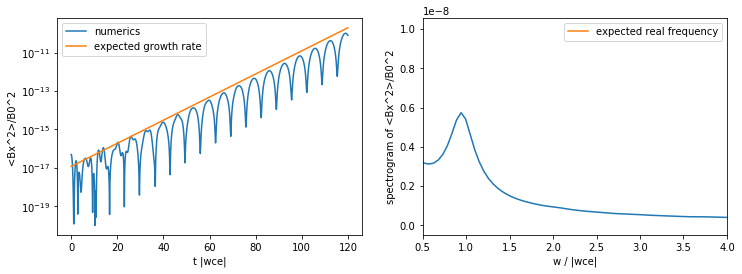

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.dispersionSolver import solveDispersion
from Utils.bsplines import Bspline



# ... import simuöation data
data = np.loadtxt('simulation_data.txt')
# ...


# ... get simulation parameters
params = data[-1,:]
s = 6


wce = params[6]
wpe = params[7]
nuh = params[8]
wpar = params[10]
wperp = params[11]
k = params[12]
Lz = params[16]
Nz = int(params[17])
T = params[18]
dt = params[19]
p = int(params[20])

Nt = int(T/dt)
Nb = Nz
dz = Lz/Nz



uj = data[0:Nt+1,0:s*Nb]
uj = np.reshape(uj,(Nt+1,Nb,s))
# ...



# ... discretization parameters
dz = Lz/Nz
zj = np.linspace(0,Lz,Nz+1)

Nt = np.int(T/dt)
tn = np.linspace(0,T,Nt+1)
# ...




# ... create B-spline basis and quadrature grid
left = np.linspace(-p*dz,-dz,p)
right = np.linspace(Lz+dz,Lz+p*dz,p)
Tbsp = np.array(list(left)  + list(zj) + list(right))
bsp = Bspline(Tbsp,p)
N = len(Tbsp) - p - 1
xi,wi = np.polynomial.legendre.leggauss(p+1)
quad_points = np.zeros((p+1)*Nz)
weights = np.zeros((p+1)*Nz)

for i in range(0,Nz):
    a1 = zj[i]
    a2 = zj[i+1]
    xis = (a2-a1)/2*xi + (a1+a2)/2
    quad_points[(p+1)*i:(p+1)*i+(p+1)] = xis
    wis = (a2-a1)/2*wi
    weights[(p+1)*i:(p+1)*i+(p+1)] = wis
# ... 



# ... assemble mass and convection matrices
M = np.zeros((Nb,Nb))            
C = np.zeros((Nb,Nb))             

for ie in range(0,Nz):
    for il in range(0,p+1):
        for jl in range(0,p+1):
                
            i = il + ie  
            j = jl + ie
                
            value_m = 0.0
            value_c = 0.0
                
            for g in range(0,p+1):
                gl = ie*(p+1) + g
                    
                value_m += weights[gl]*bsp(quad_points[gl],i,0)*bsp(quad_points[gl],j,0)
                value_c += weights[gl]*bsp(quad_points[gl],i,0)*bsp(quad_points[gl],j,1)
                    
            M[i%Nb,j%Nb] += value_m
            C[i%Nb,j%Nb] += value_c
# ...






# ... solve the dispersion relation for a fixed k to get ocillation frequency an 
omega = solveDispersion(k,-1,wce,wpe,wpar,wperp,nuh,0.5+0.05j,1e-7)
omega_r = np.real(omega)
gamma = np.imag(omega)

mean_Bx2 = np.zeros(Nt+1)

for j in range(0,Nt+1):
    mean_Bx2[j] = 1/Lz*np.dot(uj[j,:,2],np.dot(M,uj[j,:,2]))
    
spec = np.fft.fft(mean_Bx2)
spec = np.fft.fftshift(spec)
w = np.linspace(0,Nt,Nt+1) - Nt/2
w = 2*np.pi*w/T

f1 = plt.figure()
f1.set_figheight(4)
f1.set_figwidth(12)

plt.subplot(121)
plt.semilogy(tn,mean_Bx2,label = 'numerics')
plt.semilogy(tn,1.2e-17*np.exp(tn*gamma*2),label = 'expected growth rate')
plt.xlabel('t |wce|')
plt.ylabel('<Bx^2>/B0^2')
plt.legend()

plt.subplot(122)
plt.plot(w,np.abs(spec))
plt.xlim((0.5,4))
plt.xlabel('w / |wce|')
plt.ylabel('spectrogram of <Bx^2>/B0^2')
plt.plot(np.ones(20)*2*omega_r,np.linspace(0,4e-11,20),label = 'expected real frequency')
plt.legend()